# Volumetric data processing
This is a simple demo on toy 3d data for source extraction and deconvolution using CaImAn.
For more information check demo_pipeline.ipynb which performs the complete pipeline for
2d two photon imaging data.

In [1]:
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import imageio
import numpy as np
import os
import glob
import pickle
import sys
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

from bokeh.io import output_notebook 
output_notebook()

import plotly.graph_objects as go
plt.style.use('default')


2024-06-02 12:34:36.021275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 12:34:36.021389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 12:34:36.355483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading BokehJS ...

Loading BokehJS ...

In [2]:
sys.path.insert(0, '../')
from experiment_info import samples, data_dir, puffs, params
import functions as fn


## Load all segmentation results

In [3]:
results_dir = f'results/caiman/K10'
def load_C_A_matrices(results_dir, samples):
    # A matrix specifies the positions of components
    # C matrix specifies the activity of components
    A_mats = []
    C_mats = []
    for i,samp in enumerate(samples):

        try:
            with open(f'{results_dir}/{samp}_cnm2.pkl', 'rb') as f:
                cnm = pickle.load(f)
        except FileNotFoundError:
            print(f'No file found for sample {samp}')
            continue

        A = cnm.estimates.A.toarray()
        C = cnm.estimates.C

        A_mats.append(A)
        C_mats.append(C)
    return A_mats, C_mats

A_mats, C_mats = load_C_A_matrices(results_dir, samples)
print(f'Loaded {len(A_mats)} samples')
print(C_mats[0].shape)
print(A_mats[0].shape)


Loaded 15 samples
(9, 4032)
(393216, 9)


In [4]:
def split_list_by_subspecies(l):
    ORL = l[0:5]
    U52 = l[5:10]
    FCV = l[10:16]
    return ORL, U52, FCV

A_ORL_mats, A_U52_mats, A_FCV_mats = split_list_by_subspecies(A_mats)
C_ORL_mats, C_U52_mats, C_FCV_mats = split_list_by_subspecies(C_mats)
ORL_names, U52_names, FCV_names = split_list_by_subspecies(samples)

print(len(C_ORL_mats), len(C_U52_mats), len(C_FCV_mats))

5 5 5


## Load raw video data

In [ ]:
import skimage as ski

samp = ORL_names[3]

def apply_median_filter(v):
    filtered_frames = []
    for frame in v:
        filtered_frames.append( ski.filters.median(frame, behavior='ndimage') )
    return cm.movie(np.array(filtered_frames))


# store videos
videos = {}
v = glob.glob(f"{data_dir}/{samp}/*.registered.tif")
v = sorted(v)
vids = v[odor_index]

vid_list = fn.load_videos_into_list([vids], params, normalize=True)

loaded_normalized_videos = []
for vid in vid_list:
    loaded_normalized_videos.append(apply_median_filter(vid))
    # loaded_normalized_videos.append(vid)

Y = cm.concatenate(loaded_normalized_videos)


In [ ]:
Y[...,15].play(magnification=2, backend='embed_opencv', fr=30)

## makegif of raw data

In [15]:
movie_2d = np.max(Y, axis=3)
# movie_2d = Y[...,15]
movie_2d = (movie_2d - np.min(movie_2d))/(np.max(movie_2d) - np.min(movie_2d))

# Set lower intensities to zero to make background black
# threshold = 0.1  # Adjust threshold to your preference
# movie_2d[movie_2d < threshold] = 0

# to resize image, need to specify pixels, but I want to use inches like other plots
# one rule of thumb is pixels=inches×DPI, where DPI is 300 for high quality or 96 for screens
# So for 5x5 inches, each axis would need to be 96*5=480 pixels

new_width = 480  # Adjust the desired width here
new_height = 480  # Adjust the desired height here

frames = []
from skimage.transform import resize
for frame in movie_2d:
    resized_frame = resize(frame, (new_height, new_width), anti_aliasing=True)
    frames.append((resized_frame * 255).astype('uint8'))
imageio.mimsave('raw.gif', frames, fps=20, loop=0)  # You can adjust fps as needed


## Plot neural activity signal traces to select glomeruli that will be best for visualization

In [5]:
def make_plot_by_subspecies(C_mats, A_mats, samp_names, odor_names, positions):
    fig, axs = plt.subplots(1,5,figsize=(35, 6))
    for samp,(C,A) in enumerate(zip(C_mats, A_mats)):
        for seg in range(C.shape[0]):
            seg_indices = np.nonzero(A[:,seg])
            trace_mean_recontructed = np.array([np.mean(A[:,seg][seg_indices]) * C[seg,i] for i in range(C.shape[1])])
            # print(np.max(trace_mean_recontructed))
            # plot the trace directly from C matrix
            # axs[samp].plot(C[seg,:] + seg*2, c='black')  # Offset each trace by i*3
            # plot the trace from A and C matrix
            axs[samp].plot(trace_mean_recontructed + seg*0.02, c='black')
        axs[samp].set_yticks([])
        axs[samp].set_title(samp_names[samp])
        axs[samp].set_xticks(positions, odor_names, rotation=90)
        # add grid line
        axs[samp].grid(axis='x', alpha=0.2)

odor_names = []
positions = []
for i,puff in enumerate(puffs):
    if puff.trial == 1:
        odor_names.append(puff.odor_name)
        positions.append(i*params['n_frames_to_analyze'] + params['n_frames_to_analyze']/2)
    

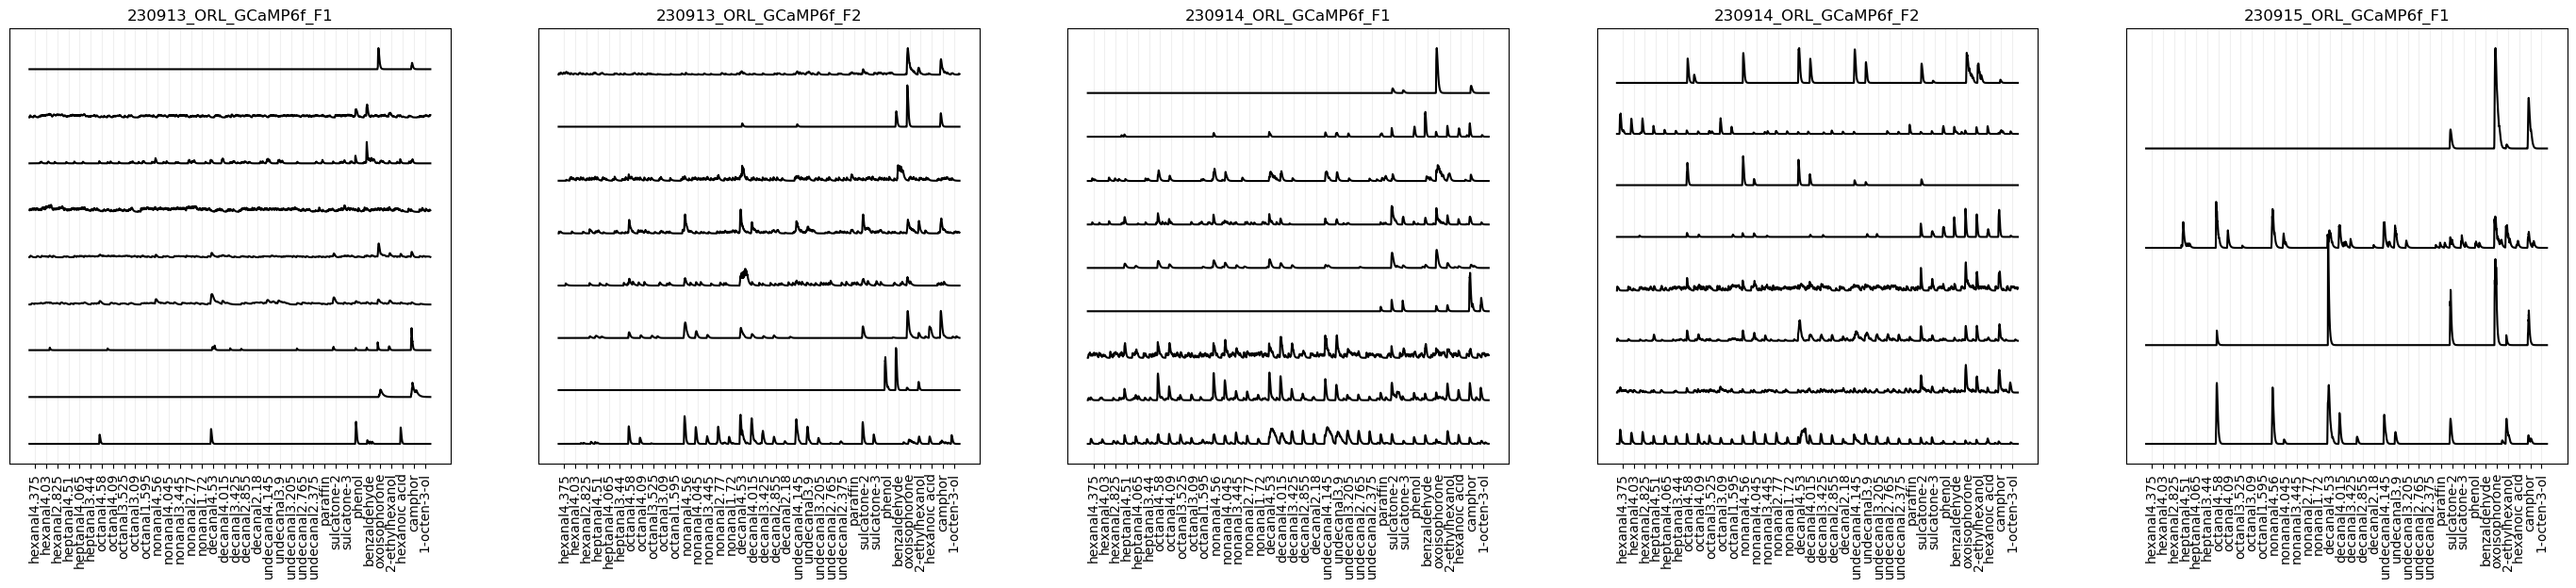

In [6]:
make_plot_by_subspecies(C_ORL_mats, A_ORL_mats, ORL_names, odor_names, positions)
# make_plot_by_subspecies(C_U52_mats, A_U52_mats, U52_names, odor_names, positions)
# make_plot_by_subspecies(C_FCV_mats, A_FCV_mats, FCV_names, odor_names, positions)

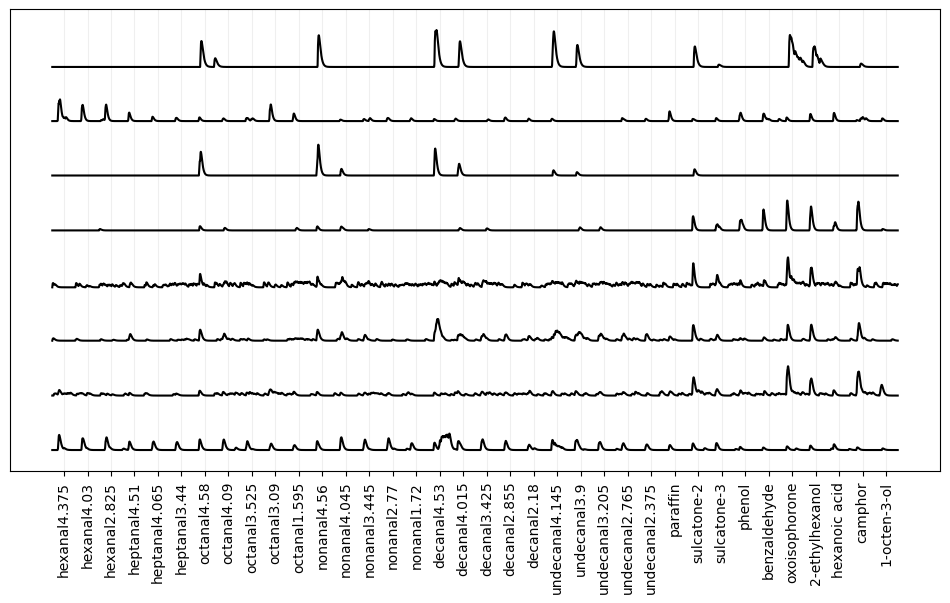

In [7]:
fig, axs = plt.subplots(1,1,figsize=(12, 6))

C, A = np.copy(C_ORL_mats[3]), np.copy(A_ORL_mats[3])

odor_names = []
positions = []
for i,puff in enumerate(puffs):
    if puff.trial == 1:
        odor_names.append(puff.odor_name)
        positions.append(i*params['n_frames_to_analyze'] + params['n_frames_to_analyze']/2)


for seg in range(C.shape[0]):
    seg_indices = np.nonzero(A[:,seg])
    trace_mean_recontructed = np.array([np.mean(A[:,seg][seg_indices]) * C[seg,i] for i in range(C.shape[1])])
    # print(np.max(trace_mean_recontructed))
    # plot the trace directly from C matrix
    # axs[samp].plot(C[seg,:] + seg*2, c='black')  # Offset each trace by i*3
    # plot the trace from A and C matrix
    plt.plot(trace_mean_recontructed + seg*0.02, c='black')
plt.yticks([])
plt.xticks(positions, odor_names, rotation=90)
# add grid line
plt.grid(axis='x', alpha=0.2)


## Make gif combining 3d scatterplot of glomeruli data along with their time traces

In [14]:
def plot_background_points(A, params, ax, quantile_thresh = 0.4):
    for i in range(A.shape[1]):
        A_tmp = np.copy(A[:,i])
        thresh = np.quantile(A_tmp[A_tmp>0], quantile_thresh)
        A_tmp[A_tmp < thresh] = 0
        A_tmp = np.reshape(A_tmp, (params['z_dim'], params['x_dim'], params['y_dim']))
        z, x, y = np.nonzero(A_tmp)
        # get unique z,x,y coordinates to avoid plotting the same point multiple times
        z, x, y = np.unique(np.array([z,x,y]), axis=1)
        # plot background, alpha=0.02 is best, anything below 0.01 goes to black
        ax.scatter(x, y, z, s=10, alpha=0.01, c='white')

def plot_segment_points(A, seg_indices, t, params, ax, z_ang, quantile_thresh = 0.8):
    A = A[:,seg_indices]
    # using reversed() here because the color palette is reversed when plotting the time traces
    for i in reversed(list(range(A.shape[1]))): # columns of X are segments
        A_tmp = np.copy(A[:,i])
        thresh = np.quantile(A_tmp[A_tmp>0], quantile_thresh)
        A_tmp[A_tmp < thresh] = 0

        A_tmp = np.reshape(A_tmp, (params['z_dim'], params['x_dim'], params['y_dim']))
        z, x, y = np.nonzero(A_tmp)

        # get coordinate of the element with the maximum value
        z_max, x_max, y_max = np.unravel_index(np.argmax(A_tmp, axis=None), A_tmp.shape)
        z_max, x_max, y_max = [z_max], [x_max], [y_max] # Convert to list to match the shape of the other arrays

        # plot activity trace
        ax.scatter(x, y, z, s=30, alpha=t[i])
        # plot segment center
        # ax.scatter(x_max, y_max, z_max, s=10, c='white')

# Function to create a 3D scatter plot
def create_3d_scatter(A, seg_indices, t, params, z_ang, ax):
    ax.set_box_aspect((1, 1, 0.33), zoom=1.3)

    # plot background
    plot_background_points(A, params, ax, quantile_thresh = 0.4)

    # plot time traces of segments indicated by seg_indices
    plot_segment_points(A, seg_indices, t, params, ax, z_ang, quantile_thresh = 0.9)

    ax.set_xlim(0, params['x_dim'])
    ax.set_ylim(0, params['y_dim'])
    ax.set_zlim(0, params['z_dim'])

    # make the grid transparent
    ax.xaxis._axinfo['grid'].update(color = (1, 1, 1, 0.1))
    
    # Completely turn off all axes
    ax.set_axis_off()

    ax.view_init(elev=45, azim=z_ang)

    # remove tick labels and numerical labels from all axes
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # ax.set_zticklabels([])

    # plt.close(fig)  # Close the figure to avoid displaying it in the notebook

    # return fig


def plot_time_traces(time_traces, ymax, xmax, y_offset, x_offset, ax):
    for i,t in reversed(list(enumerate(time_traces))):
        xvals = np.arange(len(t)) + i*x_offset
        yvals = t + (i*y_offset)
        ax.plot(xvals, yvals, linewidth=3)
        ax.set_xlim(0,xmax)
        # make y limit the sum of the max of each trace
        ax.set_ylim(-0.11, ymax)
        # turn off  y axis
        # ax.get_yaxis().set_visible(False)
        # put single x axis tick at 25
        # ax.set_xticks([25])
        # ax.set_xticklabels([name], rotation=0)

        # add thick white line to bottom of plot indicating time scale
        # volumes recorded at 4 Hz, so 1 frame = 0.25 s, 1 s = 4 frames
        ax.plot([0,4], [-0.1,-0.1], color='#feffb3', linewidth=5)
        ax.text(6/112, -0.09, '1sec', color='#feffb3', transform=ax.transAxes) # added 0 to match the number of arguments, need z bc in 3d plot

        ax.set_axis_off()

    sns.despine()
    plt.close(fig)


def make_timetrace_inset(time_traces, time, ax):
    axins = inset_axes(ax, width="30%", height="20%", loc=4)

    y_offset = 0.2*np.max(time_traces)
    x_offset = 20
    ymax = 1.2*np.max(time_traces)
    xmax = time_traces.shape[1]+x_offset

    plot_time_traces(time_traces[:,0:time], ymax, xmax, y_offset, x_offset, axins)

# Create a gif from a series of 3D scatter plots
def create_gif(A, C, odor_index, seg_indices, params, filename='timetrace.gif', duration=0.01):
    # select seg column of X such that matrix is still 2D with 1 column according to it's shape

    # normalize each individual segment of time_traces matrix
    maxs = np.max(C, axis=1)[:,None]
    mins = np.min(C, axis=1)[:,None]   
    C_normalized = (C - mins) / (maxs-mins)

    # select the frames of the odor
    start_time = odor_index*params['n_frames_to_analyze']
    end_time = (odor_index+1)*params['n_frames_to_analyze']
    # end_time = start_time+30
    time_traces = C_normalized[seg_indices, start_time:end_time]
    
    print(time_traces.shape)
    # replace nan with 0
    time_traces = np.nan_to_num(time_traces)

    # print(time_traces[:,2].shape)
    images = []
    for time in range(time_traces.shape[1]):
        # last argument is the angle of the plot, rotation about the z axis
        z_ang = time+45
        fig, ax = plt.subplots(1,1, figsize=(5, 5),subplot_kw={"projection": "3d"})
        create_3d_scatter(np.copy(A), seg_indices, time_traces[:,time], params, z_ang, ax)
        make_timetrace_inset(time_traces, time, ax)
        plt.close(fig)
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)

    imageio.mimsave(filename, images, fps=20, loop=0, duration=duration)

    return time_traces




A = A_ORL_mats[3]
C = C_ORL_mats[3]

odor_index = 1 # the index of the odor to plot, 
seg_indices = [0,6] # the indices of the segments to plot
plt.style.use('dark_background')

# params for inset
# params_inset = {}


time_traces = create_gif(A, C, odor_index, seg_indices, params)

(2, 112)


/tmp/ipykernel_211552/123713618.py:132: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


# APPENDIX

### create scale bar for physical axes

In [ ]:

def create_xyz_bar():
    # make a 3d plot with 3 lines from (0,0,0) to (1,0,0), (0,1,0), and (0,0,1)
    fig, ax = plt.subplots(1,1, figsize=(3, 3),subplot_kw={"projection": "3d"})

    # ax = fig.add_subplot(111, figsize=(3, 3), projection='3d')
    ax.plot([0,1], [0,0], [0,0], c="white", linewidth=3)
    ax.plot([0,0], [0,1], [0,0], c="white", linewidth=3)
    ax.plot([0,0], [0,0], [0,1], c="white", linewidth=3)
    ax.set_axis_off()
    ax.view_init(elev=45, azim=45)
    labels = ['X', 'Y', 'Z']
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_zticklabels(labels)
    # label each axis with 'µm'
    ax.text(1.2,0,0, 'µm', color='white') # X label
    ax.text(0.1,1.075,0, 'µm', color='white') # Y label
    ax.text(0.1,0,1.15, 'µm', color='white') # Z label
    plt.show()
    return fig

create_xyz_bar()

### make individual 3d scatterplot of glomeruli

In [ ]:

# Function to create a 3D scatter plot
def create_3d_scatter(A, seg_indices, t, params, z_ang):
    fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    fig, ax = plt.subplots(1,1, figsize=(10, 10),subplot_kw={"projection": "3d"})
    ax.set_box_aspect((1, 1, 0.33), zoom=1.3)
    # ax.set_box_aspect((1, 1, 1), zoom=1.3)

    # plot background
    quantile_thresh = 0.4
    for i in range(A.shape[1]):
        A_tmp = np.copy(A[:,i])
        thresh = np.quantile(A_tmp[A_tmp>0], quantile_thresh)
        A_tmp[A_tmp < thresh] = 0
        A_tmp = np.reshape(A_tmp, (params['z_dim'], params['x_dim'], params['y_dim']))
        z, x, y = np.nonzero(A_tmp)
        # get unique z,x,y coordinates to avoid plotting the same point multiple times
        z, x, y = np.unique(np.array([z,x,y]), axis=1)
        # plot background, alpha=0.02 is best
        ax.scatter(x, y, z, s=10, alpha=0.02, c='white')

    # plot time traces of segments indicated by seg_indices
    quantile_thresh = 0.7
    A = A[:,seg_indices]
    for i in reversed(list(range(A.shape[1]))): # columns of X are segments
        A_tmp = np.copy(A[:,i])
        thresh = np.quantile(A_tmp[A_tmp>0], quantile_thresh)
        A_tmp[A_tmp < thresh] = 0

        A_tmp = np.reshape(A_tmp, (params['z_dim'], params['x_dim'], params['y_dim']))
        z, x, y = np.nonzero(A_tmp)

        # get coordinate of the element with the maximum value
        z_max, x_max, y_max = np.unravel_index(np.argmax(A_tmp, axis=None), A_tmp.shape)
        z_max, x_max, y_max = [z_max], [x_max], [y_max] # Convert to list to match the shape of the other arrays

        # plot activity trace
        ax.scatter(x, y, z, s=30, alpha=t[i])
        # plot segment center
        # ax.scatter(x_max, y_max, z_max, s=10, c='white')

    ax.set_xlim(0, params['x_dim'])
    ax.set_ylim(0, params['y_dim'])
    ax.set_zlim(0, params['z_dim'])

    # make the grid transparent
    ax.xaxis._axinfo['grid'].update(color = (1, 1, 1, 0.1))
    
    # Adjust the aspect ratio
    # rescale = 1 # larger values (>1) zoom in but make object rotate around another central point
    # ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1*rescale, 1*rescale, 0.33*rescale, 1]))


    # Completely turn off all axes
    ax.set_axis_off()


    ax.view_init(elev=45, azim=z_ang)

    # remove tick labels and numerical labels from all axes
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    plt.close(fig)  # Close the figure to avoid displaying it in the notebook

    return fig

# Create a gif from a series of 3D scatter plots
def create_gif(A, C, odor_index, seg_indices, params, filename='timetrace.gif', duration=0.01):
    # select seg column of X such that matrix is still 2D with 1 column according to it's shape

    # normalize each individual segment of time_traces matrix
    maxs = np.max(C, axis=1)[:,None]
    mins = np.min(C, axis=1)[:,None]   
    C_normalized = (C - mins) / (maxs-mins)

    # select the frames of the odor
    start_time = odor_index*params['n_frames_to_analyze']
    end_time = (odor_index+1)*params['n_frames_to_analyze']
    # end_time = start_time+5
    time_traces = C_normalized[seg_indices, start_time:end_time]
    
    print(time_traces.shape)
    # replace nan with 0
    time_traces = np.nan_to_num(time_traces)

    # print(time_traces[:,2].shape)
    images = []
    for time in range(time_traces.shape[1]):
        # last argument is the angle of the plot, rotation about the z axis
        z_ang = time+45
        fig = create_3d_scatter(np.copy(A), seg_indices, time_traces[:,time], params, z_ang)
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)

    imageio.mimsave(filename, images, fps=20, loop=0, duration=duration)

    return time_traces

A = A_ORL_mats[3]
C = C_ORL_mats[3]
odor_index = 1 # the index of the odor to plot, 
seg_indices = [0,6] # the indices of the segments to plot
plt.style.use('dark_background')
time_traces = create_gif(A, C, odor_index, seg_indices, params)

### make invidual gif of time traces

In [ ]:

def plot_time_traces(time_traces, ymax, xmax, y_offset, x_offset, name):
    fig, ax = plt.subplots(1,1,figsize=(3, 3))
    for i,t in reversed(list(enumerate(time_traces))):
        xvals = np.arange(len(t)) + i*x_offset
        yvals = t + (i*y_offset)
        ax.plot(xvals, yvals, linewidth=3)
        ax.set_xlim(0,xmax)
        # make y limit the sum of the max of each trace
        ax.set_ylim(-0.03, ymax)
        # turn off  y axis
        ax.get_yaxis().set_visible(False)
        # put single x axis tick at 25
        ax.set_xticks([25])
        ax.set_xticklabels([name], rotation=0)

        # add thick white line to bottom of plot indicating time scale
        # volumes recorded at 4 Hz, so 1 frame = 0.25 s, 1 s = 4 frames
        ax.plot([0,4], [-0.02,-0.02], color='white', linewidth=5)
        ax.text(6/112, -0.025, '1sec', transform=ax.transAxes)
        ax.set_axis_off()

    sns.despine()
    plt.close(fig)
    return fig

plt.style.use('dark_background')

name = puffs[odor_index].odor_name

images = []
y_offset = 0.2*np.max(time_traces)
x_offset = 20
ymax = 1.2*np.max(time_traces)
xmax = time_traces.shape[1]+x_offset

for time in range(1,time_traces.shape[1]+1):
    fig = plot_time_traces(time_traces[:,0:time], ymax, xmax, y_offset, x_offset, name)
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    # image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    images.append(image)

imageio.mimsave("test.gif", images, fps=20, loop=0)
